In [1]:
# Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from scipy.signal import argrelextrema

%matplotlib inline

## Parameters
# Image specs
nxy = 512
center = int(nxy/2)

In [2]:
def atmos_sim():
    # Aperture/Telescope Specifications:
    diameter_m = 2.133 # Mirror diameter in meters
    focal_length = 129.69 # Effective focal length in meters
    wavelength = 0.8E-6 # Wavelength of light
    pixel = 8E-6 # Dimension of a pixel
    diameter_m = 2.133 # Telescope diameter in m

    nxy = 512
    center = int(nxy/2)

    ## Creating Binary Star Input Image
    # For KP 2.1m telescope, input image is in units of 25.44 milliarcseconds
    platescale = 0.02544 # Plate scale in arcsec/pixel
    rho = 1.5 # Set separation in arcseconds
    phi = 45 # Set angle in degrees
    # Calculate coordinates of stars
    x = int( rho/(2*platescale) * np.cos(np.deg2rad(phi)) )
    y = int( rho/(2*platescale) * np.sin(np.deg2rad(phi)) )
    x1 = center + x
    y1 = center + y
    x2 = center - x
    y2 = center - y    
    # Empty input image
    input_img = np.zeros((nxy,nxy)) 
    # Place stars on image
    input_img[y1,x1] = 1 
    input_img[y2,x2] = 1
    # Scale image power to 1
    input_img_power = np.sum(np.power(input_img,2))
    input_img = np.divide(input_img,np.sqrt(input_img_power))

    ## Telescope aperture creation:
    # Total spatial sample range
    X_aperture_s = 1/pixel 
    # dx value for sampled aperture image
    dx_aperture_s = X_aperture_s/nxy 
    # Coordinates of sampled image
    x_aperture_s = np.arange(0,X_aperture_s,dx_aperture_s) - X_aperture_s/2
    # Meshgrid of sampled coordinates
    xx_s,yy_s = np.meshgrid(x_aperture_s,x_aperture_s)
    # Scaled aperture diameter to effectively resample aperture image
    diameter_s = diameter_m/(focal_length*wavelength)
    # Draw new circle at correct dimensions
    # Calculate grid of distances from circle center
    circle_s = (xx_s) ** 2 + (yy_s) ** 2 
    # Draw boolean circle
    circle_s = circle_s < (diameter_s/2)**2 
    # Convert boolean circle to int
    circle_s= circle_s.astype(np.int64)
    # Save aperture image in units of meters
    aperture_screen_s = circle_s
    # Scale aperture image power to 1
    aperture_screen_power = np.sum(np.power(aperture_screen_s,2))
    aperture_screen_s = np.divide(aperture_screen_s,np.sqrt(aperture_screen_power))
    # Calculate effective size of sampled aperture image in meters
    X_aperture_s_meff = focal_length*wavelength/pixel
    
    ## Phase screen creation:
    # Generate random image
    # To be used in creating random atmospheric element
    phase_phase = np.multiply(np.pi,np.random.normal(loc=0,scale=1,size=(nxy,nxy)))
    # Total array sample size
    d_aperture = X_aperture_s_meff
    # Fried parameter [m]
    r0 = 0.2
    # Spatial sample resolution
    dxy = d_aperture/nxy
    # Spatial frequency resolution
    df = 1/(d_aperture) 
    # Image sample indices array
    x = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), dxy )
    # Spatial Frequency indices array
    xf = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), df )
    # Meshgrid of spatial frequency domain
    [xx,yy]=np.meshgrid(xf,xf)
    # Radius from center meshgrid
    rr = (np.sqrt(np.power(xx,2)+np.power(yy,2)))
    # Calculate Kolmogorov spectral density
    alpha = 1/100
    phase_PSD = np.power(rr,-11/3)
    phase_PSD = np.multiply(alpha*0.023/(r0**(5/3)),phase_PSD)
    # Set DC component to 0 (previous calc attempts to set to 1/0)
    phase_PSD[int(nxy/2),int(nxy/2)] = 0 
    # Construct phase screen spectrum
    phase_screen_f = np.multiply(np.sqrt(phase_PSD),np.exp(1j*phase_phase))
    # Calculate phase screen
    phase_screen = np.real(ifft2(fftshift(phase_screen_f)*nxy*nxy))
    # Create complex atmospheric screen
    atmosphere_screen = np.exp(np.multiply(1j,phase_screen))

    # Generate total screen, combining atmosphere and aperture
    pupil_screen = np.multiply(atmosphere_screen,aperture_screen_s)

    ## Calculate system's total response 
    # Calculate total PSF of system
    psf = fftshift(fft2(pupil_screen))
    psf = np.power(np.abs(psf),2)
    # Normalize PSF
    psf_power = np.sum(np.power(psf,2))
    psf = np.divide(psf,psf_power)
    # Gamma correct PSF
    gamma = 1.6
    psf = np.power(psf,1/gamma)  
    # Convolve PSF with input image using FFT
    sensor_img = fftconvolve(input_img,psf)
    # Save the center 512x512 image
    sensor_img = sensor_img[center:center+nxy,center:center+nxy]
    
    return (psf, sensor_img)

In [10]:
## Adding noise to images
def add_gaus_noise(img, var):
    # Size of input image?
    nxy = np.shape(img)[0]
    
    # Array to be returned
    img_noisy = np.zeros((nxy,nxy))    
    
    # Create noise image
    noise = np.random.normal(loc=0,scale=var,size=(nxy,nxy))
    # Add noise image to simulated image
    img_noisy = img+noise
    # Turn all negative pixels to 0
    img_noisy[img_noisy<0] = 0
    
    # Return noisy image
    return img_noisy

In [11]:
def add_shot_noise(img, photons):
    # Size of input image?
    nxy = np.shape(img)[0]    
    
    # Empty arrays to use
    img_normalized = np.zeros((nxy,nxy))
    img_scaled = np.zeros((nxy,nxy))
    img_shot_noise = np.zeros((nxy,nxy))
    
    # Normalize input image
    img_normalized = np.abs(img)/(np.sum(img))
    # Scale image to number of photons desired
    img_scaled = img_normalized*photons
    # Calculate image with shot noise
    img_shot_noise = np.random.poisson(lam=img_scaled, size=None)

    # Return noisy image
    return img_shot_noise

In [19]:
# Creating empty arrays for simulated data
nxy = 512
img = np.zeros((nxy,nxy))
img_noise1 = np.zeros((nxy,nxy))
img_noise2 = np.zeros((nxy,nxy))
img_noise3 = np.zeros((nxy,nxy))

binary_img = np.zeros((nxy,nxy))

# Calculate simulated binary/reference images
(img, binary_img) = atmos_sim()


/home/niels/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in power


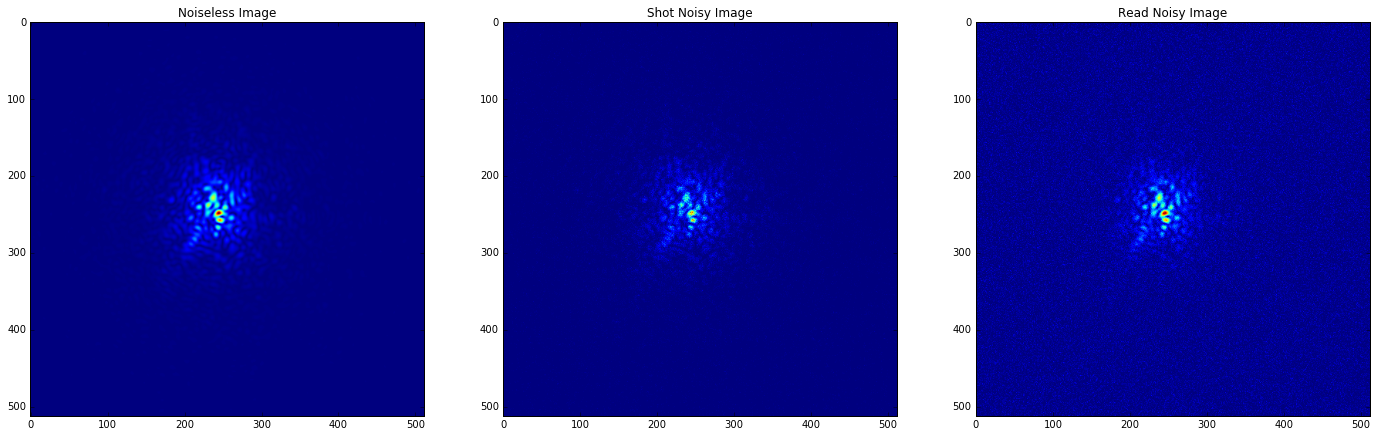

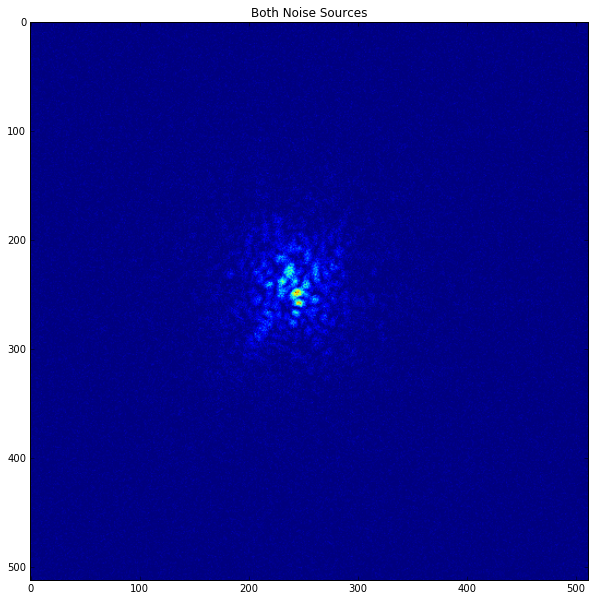

In [29]:
## Adding noise to images
shot_photons = 100000
gaus_var = 5E-4
img_noise1 = add_shot_noise(img, photons=100000)
img_noise2 = add_gaus_noise(img, var=5E-5)
img_noise3 = add_gaus_noise(img_noise1,1)

# Display figures
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.title("Noiseless Image")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Shot Noisy Image")
plt.imshow(img_noise1)

plt.subplot(1,3,3)
plt.title("Read Noisy Image")
plt.imshow(img_noise2)

plt.figure(figsize=(10,10))
plt.title("Both Noise Sources")
plt.imshow(img_noise3)

In [30]:
# Calculate PSD of noisy images
psd_img = fftshift(np.abs(fft2(img))**2)
psd_noise3 = fftshift(np.abs(fft2(img_noise3))**2)

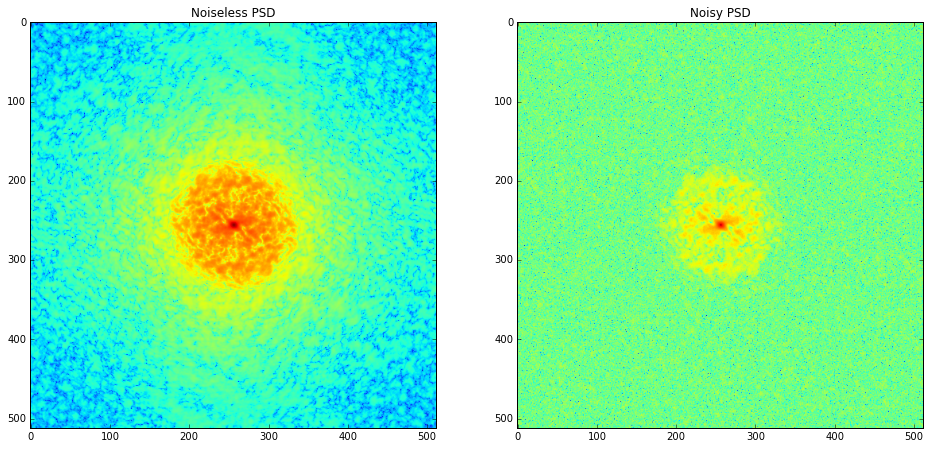

In [32]:
# Display reference and binary PSDs
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(np.log10(psd_img))
plt.title("Noiseless PSD")
plt.subplot(1,2,2)
plt.imshow(np.log10(psd_noise3))
plt.title("Noisy PSD")